# QM9 training example

This notebook contains an end-to-end example to train a GAN model on a specific set of molecules and visualize the generated structures. It uses molecules from the QM9 database as training examples and NeuralIL's descriptor generator method.  

If you do not have enough compute available, please check the "QM9 filter example" to use an already trained model.

In [1]:
from besselgan.models import GeneratorModel, CriticModel
from besselgan.training import *
from besselgan.utilities import *
from neuralil.bessel_descriptors import PowerSpectrumGenerator

import optax
import flax.linen as nn

import jax
import jax.numpy as jnp
import numpy as np

from ase import Atoms
from ase.visualize import view
import matplotlib.pyplot as plt

import pickle

We generate rattled versions of all C4H10O and C6H14O isomers as training data.

In [2]:
allatoms = pickle.load(open("QM9_data/train_atoms.pck", "rb"))

N_RATTLE = 20
RATTLESIZE = 0.05

train_formulas = ["C4H10O", "C6H14O"]

train_atoms = []
for atoms in allatoms:
    if atoms.get_chemical_formula() in train_formulas:
        for i in range(N_RATTLE):
            tmp = atoms.copy()
            tmp.rattle(RATTLESIZE)
            train_atoms.append(tmp)

anum_map = make_atomic_number_map(train_atoms)
N_TYPES = len(anum_map)
reverse_anum_map = {}
for elem in anum_map:
    reverse_anum_map[anum_map[elem]] = elem

As descriptors we use the per atom flattened version of NeuralIL's descriptors extended with a one-hot encoding of the atom type.

In [3]:
R_CUT = 5
N_MAX = 4
N_NEIG = 10
descriptor_generator = PowerSpectrumGenerator(N_MAX, R_CUT, N_TYPES, N_NEIG)


@jax.jit
def desc_generator_method(allpos, alltype, pos, types, cell):
    desc = descriptor_generator.process_some_data(allpos, alltype, pos, cell)
    desc = jnp.reshape(desc, (pos.shape[0], -1))
    desc = jnp.append(desc, jax.nn.one_hot(types, N_TYPES), axis=1)

    return desc


training_dict = make_training_dict(train_atoms, desc_generator_method, anum_map)

Define the necessary parameters of the generator and critic models.  
Since the generator (with the postprocessing) generates the atoms in a cell, it has to be specified to a realistic size.  If the cell is too small we are unable to generate realistic structures, if it is too large the training becomes unstable, since if atoms are spread out more than R_CUT far away from eachother the generator gets no gradient information during the training.

The postprocessing step returns with ```np.zeros((3,3))``` unit cell, since that is used to turn off the PBC in the descriptor generation.

In [4]:
SEED = 333
rng = jax.random.PRNGKey(SEED)

N_DIMENSIONS = 3
N_LATENT = 20
TYPES = np.array([6] * 5 + [1] * 12 + [8])
TYPES = np.array([anum_map[t] for t in TYPES])
N_POINTS = len(TYPES)
GEN_CELL = jnp.array([[8.0, 0.0, 0.0], [0.0, 7.0, 0.0], [0.0, 0.0, 6.0]])

GENERATOR_SHAPE = [512, 256, 128, 64, 32]
CRITIC_SHAPE = [256, 128, 64, 32]

N_BATCH = 15
N_CRIT = 5
N_GP_PER_CRIT = 2

LR_CRIT = 10**-3.5
LR_GEN = 10**-3.5


def postprocess(intermediate):
    pos = intermediate.reshape((N_POINTS, N_DIMENSIONS))
    pos = jnp.matmul(pos, GEN_CELL)
    return pos, TYPES, pos, TYPES, jnp.zeros(shape=(3, 3))

In [5]:
generator = GeneratorModel(
    features=GENERATOR_SHAPE,
    n_points=N_POINTS,
    n_dimensions=N_DIMENSIONS,
    n_latent=N_LATENT,
    n_scalars=0,
)

critic = CriticModel(features=CRITIC_SHAPE)

optimizer_gen = optax.rmsprop(LR_GEN)
optimizer_crit = optax.rmsprop(LR_CRIT)

In [6]:
rng, key = jax.random.split(rng)
params_gen = generator.init(key, jax.random.normal(key, shape=(N_LATENT,)))
rng, key = jax.random.split(rng)
params_crit = critic.init(key, training_dict[0][0])

opt_state_gen = optimizer_gen.init(params_gen)
opt_state_crit = optimizer_crit.init(params_crit)

Define the full training step.

In [7]:
train_step = jax.jit(create_full_training_step(
    critic,
    generator,
    desc_generator_method,
    postprocess,
    TYPES,
    training_dict,
    optimizer_crit,
    optimizer_gen,
    N_BATCH,
    N_CRIT,
    N_GP_PER_CRIT,
))

Utility functions to hide explicit dependence on the critic, postprocessing, etc...

In [8]:
eval_single_desc = create_evaluate_single_descriptor(critic)
eval_batch_desc = create_evaluate_batch_descriptor(critic)

generate_single_desc = create_generate_descriptor(desc_generator_method)
generate_batch_desc = create_generate_batch_descriptor(desc_generator_method)

generate_structures = create_generate_structures(generator, postprocess, N_LATENT)

In [9]:
sampler = make_real_sampler(TYPES, N_BATCH, training_dict)

In [10]:
real_preds = []
fake_preds = []
gen_snapshots = []
crit_snapshots = []

Start the training. Snapshots are taken every 100 iteration.

For reasonable results longer training is needed, this is here only for illustration.

In [11]:
for i in range(60*100+1):
    if i % 100 == 0:
        rng, key = jax.random.split(rng)
        allpos, alltype, pos, type, cell = generate_structures(params_gen, key, N_BATCH)
        desc = generate_batch_desc(allpos, alltype, pos, type, cell)
        desc = desc.reshape((-1, desc.shape[-1]))

        pred_fake = np.mean(eval_batch_desc(params_crit, desc))
        real_desc, rng = sampler(rng)
        real_desc = real_desc.reshape((N_BATCH * N_POINTS, -1))
        pred_real = np.mean(eval_batch_desc(params_crit, real_desc))

        real_preds.append(pred_real)
        fake_preds.append(pred_fake)

        print(i, pred_fake, pred_real, pred_fake - pred_real)

        gen_snapshots.append(params_gen)
        crit_snapshots.append(params_crit)

    params_gen, opt_state_gen, params_crit, opt_state_crit,  rng = train_step(
        params_gen, opt_state_gen, params_crit, opt_state_crit,  rng
    )

/home/pkovacs/miniconda3/envs/BesselGAN2/lib/python3.9/site-packages/flax/core/scope.py:600: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/home/pkovacs/miniconda3/envs/BesselGAN2/lib/python3.9/site-packages/flax/core/scope.py:601: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


0 0.28746864 0.01782541 0.26964325
100 0.08528293 -0.16612685 0.25140977
200 0.015353517 -0.23254223 0.24789575
300 0.031665172 -0.2102621 0.24192728
400 0.016471019 -0.21722135 0.23369236
500 0.04586989 -0.19637713 0.24224702
600 0.012603712 -0.21559347 0.22819719
700 0.06759665 -0.1738746 0.24147126
800 0.04096154 -0.20252052 0.24348205
900 0.022097846 -0.19332337 0.21542121
1000 0.025083546 -0.22170381 0.24678735
1100 0.039747752 -0.20162667 0.24137443
1200 -0.029840998 -0.23500624 0.20516524
1300 0.029468656 -0.17869164 0.2081603
1400 0.017609034 -0.17575598 0.19336501
1500 0.021455301 -0.17716067 0.19861597
1600 0.004537071 -0.1904732 0.19501027
1700 0.02629244 -0.164017 0.19030945
1800 0.055002294 -0.14210749 0.19710979
1900 0.06525873 -0.1364656 0.20172432
2000 0.0697515 -0.13564503 0.20539653
2100 0.08876885 -0.102795444 0.19156429
2200 0.1139537 -0.07466772 0.18862143
2300 0.12666121 -0.053704873 0.18036608
2400 0.13437839 -0.045711324 0.18008971
2500 0.13774805 -0.049003404 0

Text(0.5, 0, 'Epoch')

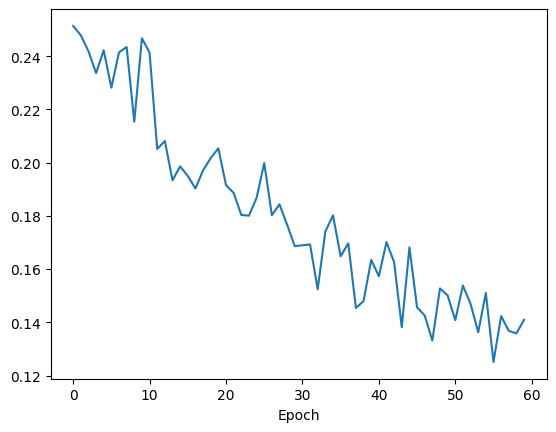

In [12]:
plt.plot(np.array(fake_preds)[1:] - np.array(real_preds)[1:])
plt.xlabel("Epoch")

Generate and visualize a structure. Rerunning the cell can result in different structures.

In [16]:
rng, key = jax.random.split(rng)
all_pos, all_type, _, _, _ = generate_structures(params_gen, key, 1)
atom = Atoms(positions=all_pos[0])
atom.center(about=0)
atom.set_atomic_numbers(
    np.array([reverse_anum_map[int(i)] for i in all_type[0]]).flatten()
)
view(atom, viewer="x3d")